In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
newparams = {'figure.figsize': (8.0, 4.0), 'axes.grid': True,
             'lines.markersize': 8, 'lines.linewidth': 2,
             'font.size': 14}
from matplotlib import cm
plt.rcParams.update(newparams)
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from numpy import linalg as la

In [2]:
def tridiag(lower, diag, upper, size):
    A=np.diag(lower, -1) + np.diag(diag) + np.diag(upper, 1)
    return A

tridiag([2,2,2], [3,3,3,3], [4,4,4], 4)

array([[3, 4, 0, 0],
       [2, 3, 4, 0],
       [0, 2, 3, 4],
       [0, 0, 2, 3]])

In [31]:
R=10
M=100
T=2
N=1000
sigma_1=1/10
sigma_2=1/5
r=0.01
c=1
K_but=3
H_but=1


def phi(sigma_1, sigma_2, h, U):
    one = np.ones(np.shape(U))
    return sigma_1**2*one + ((sigma_2**2-sigma_1**2)/2)*(one+2/np.pi*np.arctan(U/h**2))


def butterfly(x):
    term1=np.array(x-K_but) #First term
    for i in range(len(term1)):
        term1[i] = max(term1[i], 0)
    term2=np.array(x-(K_but+H_but)) #Second term
    for i in range(len(term2)):
        term2[i] = max(term2[i], 0)
    term3=np.array(x-(K_but+2*H_but)) #Third term
    for i in range(len(term3)):
        term3[i] = max(term3[i], 0)
    butterfly=term1-2*term2+term3
    return butterfly


def boundary_0(t=None, u_0=K_but, x=None):  
    return u_0*np.exp(-c*t)

def boundary_R_but(R, x=None, t=None):
    butterfly=max(R-K_but, 0) - 2*max((R-(K_but+H_but)), 0) + max((R-(K_but+2*H_but)), 0)
    return butterfly



def IMEX_method(R, M, T, N, sigma_1, sigma_2, r, c, IC, strike_K, strike_H, BC0, BCR, 
                RHS_func=lambda x, t: np.zeros((len(x), len(t))) ):
    h=R/M
    k=T/N
    
    U=np.zeros((M+1, N+1))        #How to choose M?   MxN matrix still, easier plots
    x=np.linspace(0, R, (M+1))    #Remember to add stability condition with positive coefficient in tridiag
    t=np.linspace(0, T, N+1)      #Probably necessary to have many more timesteps and spacesteps for conv
    
    U[:, 0]=IC(x)
    U[0, :]=BC0(t=t, x=x, u_0=IC(x)[0])
    U[-1, :]=BCR(R, x=x, t=t)
        
    X = np.diag(np.linspace(0, R, (M-1)))
    a = tridiag(np.ones(M-2), -2*np.ones(M-1), np.ones(M-2),M-1)
    
    #q=np.zeros(M+1)
                
    F=RHS_func(x, t)[1:-1, :]
    q=np.zeros(M-1)
    
    print(RHS_func(x,t))
    for n in range(N):
        
        U_n=U[1:-1, n]
        
        y = (a.dot(U_n))
        z = (k/(2*h**2))*(np.square(X).dot(phi(sigma_1, sigma_2, h, y)))
        A = tridiag(-z[1:],1+2*z, -z[:-1],M-1)
        
        q[0]=U[1,n] #*((k*x[1]**2/(2*h**2))*phi(sigma_1, sigma_2, h, y[1]))
        q[-1]=U[-2, n] #*((k*x[-2]**2/(2*h**2))*phi(sigma_1, sigma_2, h, y[-2]))
        
        
        #U[:,n+1] = la.solve(A,(U_n + k*q))
        
        U[1:-1,n+1] = la.inv(A)@(U_n + k*q + k*F[:, n])
        
        #U[-1, n+1]=BCR(R, t=t[n+1])
    return x, t, U

def plot_solution(x1, t1, U1, method, title):
    # Plot the solution of the heat equation
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 7), subplot_kw={"projection": "3d"})
    T1, X1 = np.meshgrid(t1, x1)
    ax.plot_surface(T1, X1, U1, cmap=cm.coolwarm)
    ax.view_init(azim=30)              # Rotate the figure
    ax.set_title(title)
    ax.set_xlabel('t')
    ax.set_ylabel('x')
    ax.set_zlabel('u')
    
    fig.tight_layout()
    if method==0:
        fig.suptitle("Euler", fontsize=14)
    if method==1:
        fig.suptitle("Backward Euler", fontsize=14)
    if method==2:
        fig.suptitle("Crank Nicholson", fontsize=14)
    if method==3:
        fig.suptitle("IMEX", fontsize=14);

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


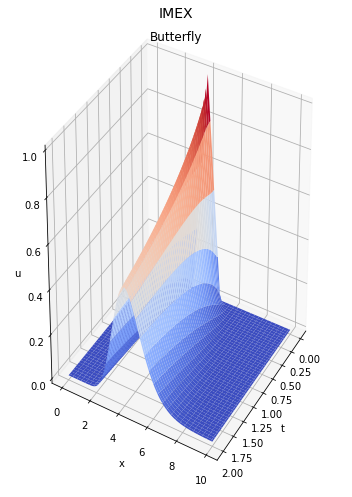

In [13]:
x, t, U=IMEX_method(R, M, T, N, sigma_1, sigma_2, r, c, butterfly, K_but, H_but, boundary_0, boundary_R_but)

plot_solution(x, t, U, 3, "Butterfly")

[[ 0.00000000e+00 -1.99999867e-03 -3.99998933e-03 ... -9.10954735e-01
  -9.10127901e-01 -9.09297427e-01]
 [ 1.09350967e-04 -1.89064770e-03 -3.89063837e-03 ... -9.10845384e-01
  -9.10018550e-01 -9.09188076e-01]
 [ 4.16421150e-04 -1.58357752e-03 -3.58356818e-03 ... -9.10538314e-01
  -9.09711480e-01 -9.08881006e-01]
 ...
 [-1.42724220e-01 -1.44724218e-01 -1.46724209e-01 ... -1.05367896e+00
  -1.05285212e+00 -1.05202165e+00]
 [-1.80238984e-01 -1.82238983e-01 -1.84238973e-01 ... -1.09119372e+00
  -1.09036689e+00 -1.08953641e+00]
 [-2.16653622e-01 -2.18653621e-01 -2.20653612e-01 ... -1.12760836e+00
  -1.12678152e+00 -1.12595105e+00]]


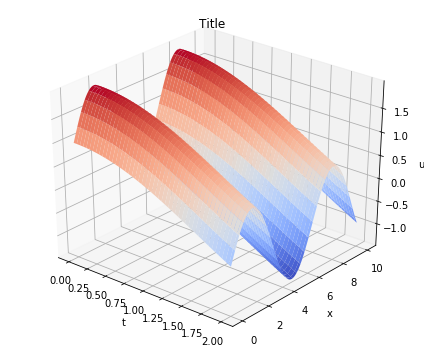

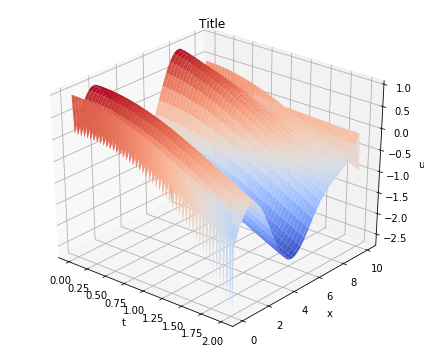

In [34]:
def plot_solutionTest(U, angle=-30, title="Title"):
    x_len = len(U[:,])
    t_len = len(U[0])
    
    x=np.linspace(0, R, x_len) 
    t=np.linspace(0, T, t_len)
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 5), subplot_kw={"projection": "3d"})
    tt, xx = np.meshgrid(t, x)
    ax.plot_surface(tt, xx, U, cmap=cm.coolwarm)
    ax.view_init(azim=angle)              # Rotate the figure
    ax.set_title(title)
    ax.set_xlabel('t')
    ax.set_ylabel('x')
    ax.set_zlabel('u')
    fig.tight_layout()

def RHS_analytic(x,t):
    tt, xx = np.meshgrid(t, x)
    return -np.sin(tt)+(xx*2/2)*np.sin(xx)*phi(sigma_1, sigma_2, R/M, -np.sin(xx)) #tt**2 - (xx**3)*phi(sigma_1, sigma_2, R/M, 2*xx)

def u_analytic(x, t):
    return np.cos(t) + np.sin(x)

def an_initial(x):
    return np.sin(x)

def an_boundary_0(t=None, u_0=K_but, x=None):
    return np.cos(t)

def an_boundary_R(R, x=None, t=None):
    return np.cos(t) + np.sin(R)



x_nonlinear=np.linspace(0, R, M+1)    #Remember to add stability condition with positive coefficient in tridiag
t_nonlinear=np.linspace(0, T, N+1)

tt_non, xx_non=np.meshgrid(t_nonlinear, x_nonlinear)

u_exact=u_analytic(xx_non, tt_non)


x_test, t_test, U_test=IMEX_method(R, M, T, N, sigma_1, sigma_2, r, c, an_initial, 3, 1, an_boundary_0, an_boundary_R, RHS_func=RHS_analytic)


plot_solutionTest(u_exact, angle=-50)

plot_solutionTest(U_test, angle=-50)



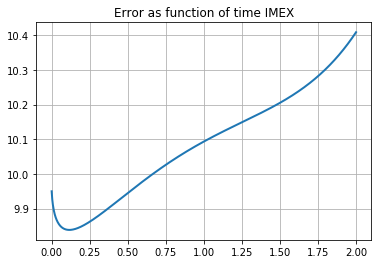

In [27]:
def error_func(u_numeric, u_analytic):
    error= np.zeros(len(u_numeric[0]))
    for i in range(len(error)):
        error[i] = la.norm(u_numeric[:,i] - u_analytic[:,i] ) #Assume 2-norm
    return error

error_IMEX = error_func(u_exact, U_test)
plt.title("Error as function of time IMEX")
plt.plot(t, error_IMEX)
plt.show()